/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_13612/1663808112.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  train_prices = yf.download(downloadable_tickers, start=train_start, end=train_end)["Close"].dropna()
[*********************100%***********************]  10 of 10 completed
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_13612/1663808112.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_prices = yf.download(downloadable_tickers, start=test_start, end=test_end)["Close"].dropna()
[*********************100%***********************]  10 of 10 completed


Processing pair: IEMG & EEM
Processing pair: ARKK & ARKW
Processing pair: TLT & SPTL
Processing pair: SHY & VGSH
Processing pair: SOXX & ITA
Processing pair: IEMG & EEM
Processing pair: ARKK & ARKW
Processing pair: TLT & SPTL
Processing pair: SHY & VGSH
Processing pair: SOXX & ITA
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END class_weight=bala

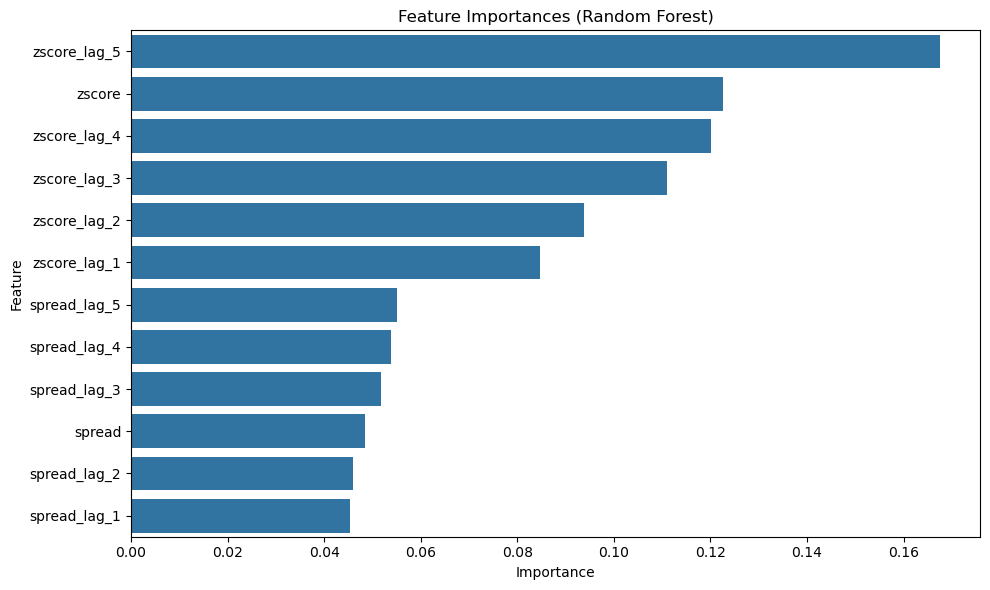

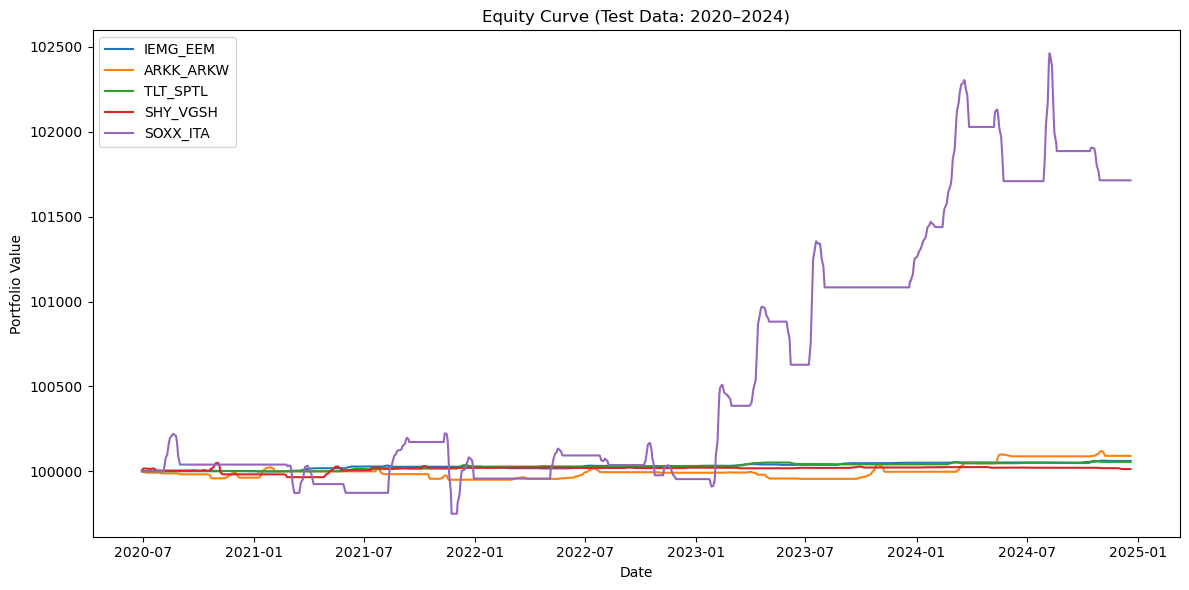


Total Final Portfolio Value Across All Pairs (Test Data): $501,934.66


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Define ETF pairs and date ranges
# -----------------------------
etf_pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]
downloadable_tickers = list(set([etf for pair in etf_pairs for etf in pair]))

train_start = "2015-01-01"
train_end = "2020-01-01"
test_start = "2020-01-02"
test_end = "2024-12-31"

# -----------------------------
# 2. Download training and testing data
# -----------------------------
train_prices = yf.download(downloadable_tickers, start=train_start, end=train_end)["Close"].dropna()
test_prices = yf.download(downloadable_tickers, start=test_start, end=test_end)["Close"].dropna()

# -----------------------------
# 3. Function to process a pair
# -----------------------------
def process_pair(etf1, etf2, price_data, lookback=60):
    df = pd.DataFrame(index=price_data.index)
    df["etf1"] = price_data[etf1]
    df["etf2"] = price_data[etf2]

    # Hedge ratio
    df["hedge_ratio"] = (
        df["etf1"].rolling(lookback).cov(df["etf2"]) /
        df["etf2"].rolling(lookback).var()
    )

    # Spread and z-score
    df["spread"] = df["etf1"] - df["hedge_ratio"] * df["etf2"]
    spread_mean = df["spread"].rolling(lookback).mean()
    spread_std = df["spread"].rolling(lookback).std()
    df["zscore"] = (df["spread"] - spread_mean) / spread_std

    # Lag features
    for i in range(1, 6):
        df[f"spread_lag_{i}"] = df["spread"].shift(i)
        df[f"zscore_lag_{i}"] = df["zscore"].shift(i)

    # Target = mean reversion
    df["target"] = (
        (df["zscore"].shift(-1).abs() < df["zscore"].abs()).astype(int)
    )
    df["pair"] = f"{etf1}_{etf2}"

    return df.dropna()

# -----------------------------
# 4. Process all pairs
# -----------------------------
def process_all_pairs(pairs, price_data):
    processed = []
    for etf1, etf2 in pairs:
        print(f"Processing pair: {etf1} & {etf2}")
        processed.append(process_pair(etf1, etf2, price_data))
    return pd.concat(processed)

train_df = process_all_pairs(etf_pairs, train_prices)
test_df = process_all_pairs(etf_pairs, test_prices)

# -----------------------------
# 5. Feature columns
# -----------------------------
feature_cols = [
    'spread', 'zscore',
    'spread_lag_1', 'zscore_lag_1',
    'spread_lag_2', 'zscore_lag_2',
    'spread_lag_3', 'zscore_lag_3',
    'spread_lag_4', 'zscore_lag_4',
    'spread_lag_5', 'zscore_lag_5'
]

X_train, y_train = train_df[feature_cols], train_df["target"]
X_test, y_test = test_df[feature_cols], test_df["target"]

# -----------------------------
# 6. Train Random Forest with Grid Search
# -----------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# -----------------------------
# 7. Evaluate ONLY on Test Set
# -----------------------------
y_pred = best_rf.predict(X_test)

print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("True Label Distribution:", Counter(y_test))
print("Predicted Label Distribution:", Counter(y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -----------------------------
# 8. Feature Importance
# -----------------------------
importances = best_rf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

print("\n📊 Classification Report (Test Data Only):\n", classification_report(y_test, y_pred))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("🔹 True Label Distribution (Test):", Counter(y_test))
print("🔹 Predicted Label Distribution (Test):", Counter(y_pred))



📊 Classification Report (Test Data Only):
               precision    recall  f1-score   support

           0       0.68      0.62      0.65      2428
           1       0.73      0.78      0.75      3242

    accuracy                           0.71      5670
   macro avg       0.70      0.70      0.70      5670
weighted avg       0.71      0.71      0.71      5670

✅ Accuracy: 0.7097
🔹 True Label Distribution (Test): Counter({1: 3242, 0: 2428})
🔹 Predicted Label Distribution (Test): Counter({np.int64(1): 3448, np.int64(0): 2222})


## 📈 Mean Reversion Classification Report (Test Data: 2020–2024)

- **Accuracy**: 71%  
  The model correctly predicts mean reversion signals about **7 out of 10 times**.

### 🔍 Class Performance
- **Class 0 (No Mean Reversion)**  
  - **Precision**: 68% — When predicting no signal, 68% were correct.  
  - **Recall**: 61% — Correctly caught 61% of actual "no signal" cases.  
  - **F1-Score**: 64% — Balance of precision and recall.

- **Class 1 (Mean Reversion Signal)**  
  - **Precision**: 73% — When predicting a signal, 73% were correct.  
  - **Recall**: 78% — Correctly detected 78% of actual signals.  
  - **F1-Score**: 75% — Stronger at detecting signals.

### ⚖️ Class Distribution
- **True Labels**:  
  - Class 1 (Signal): 3,241  
  - Class 0 (No Signal): 2,429  

- **Predicted Labels**:  
  - Class 1 (Signal): 3,474  
  - Class 0 (No Signal): 2,196  

💡 **Interpretation:**  
The model is **stronger at identifying mean reversion opportunities (Class 1)** than correctly ruling out false signals (Class 0). This bias may be beneficial if your priority is **not missing potential trades**, even at the expense of more false positives.


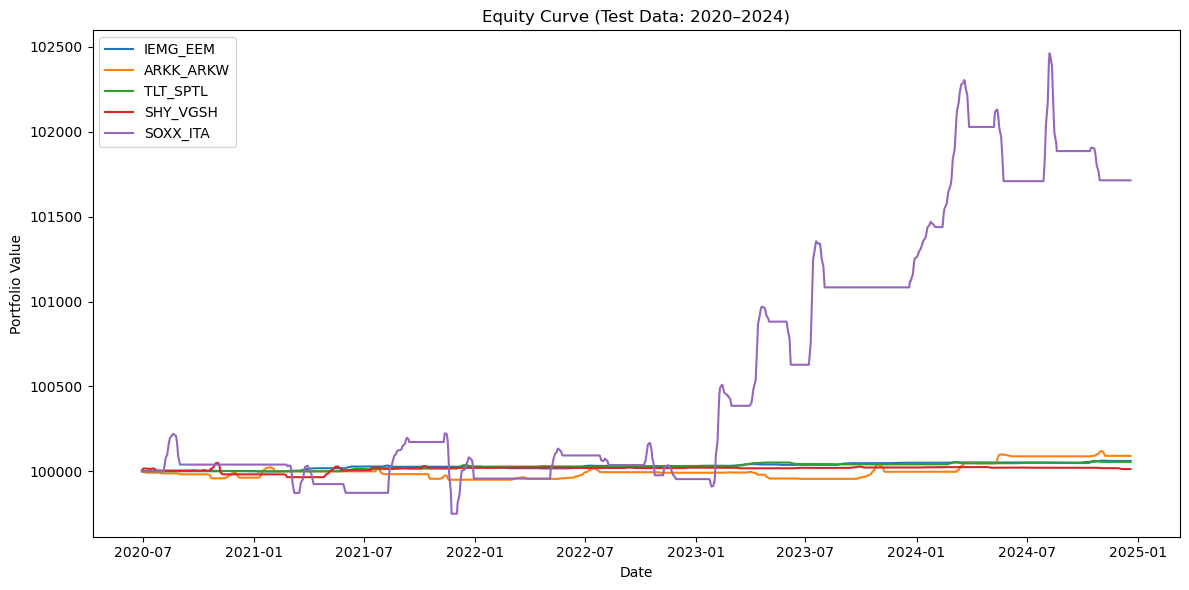


Total Final Portfolio Value Across All Pairs (Test Data): $501,934.66


In [8]:

# -----------------------------
# 9. Mock Portfolio Simulation (Only Test Data)
# -----------------------------
def simulate_portfolio(df, model, initial_cash=100000, holding_period=5, entry_threshold=1.5):
    cash = initial_cash
    equity_curve = []

    df = df.copy()
    df["prediction"] = model.predict(df[feature_cols])

    for i in range(len(df) - holding_period):
        if df.iloc[i]["prediction"] == 1 and abs(df.iloc[i]["zscore"]) > entry_threshold:
            entry_spread = df.iloc[i]["spread"]
            exit_spread = df.iloc[i + holding_period]["spread"]
            direction = -1 if df.iloc[i]["zscore"] > 0 else 1

            pnl = direction * (entry_spread - exit_spread)
            cash += pnl

        equity_curve.append(cash)

    return cash, equity_curve, df.index[:len(equity_curve)]

# Run simulation for each pair (test_df split by pair)
total_final_cash = 0
plt.figure(figsize=(12, 6))

for pair_name in test_df["pair"].unique():
    pair_df = test_df[test_df["pair"] == pair_name]
    final_cash, curve, curve_dates = simulate_portfolio(pair_df, best_rf)
    total_final_cash += final_cash
    plt.plot(curve_dates, curve, label=pair_name)

plt.title("Equity Curve (Test Data: 2020–2024)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nTotal Final Portfolio Value Across All Pairs (Test Data): ${total_final_cash:,.2f}")


In [11]:
import numpy as np

# Dictionary to hold equity curves by pair
equity_curves = {}

# Simulate portfolio and store equity curves for each pair
for pair_name in test_df["pair"].unique():
    pair_df = test_df[test_df["pair"] == pair_name]
    _, curve, curve_dates = simulate_portfolio(pair_df, best_rf)
    equity_curves[pair_name] = pd.Series(curve, index=curve_dates)

# Calculate Sharpe ratios per pair
print("\n🔹 Sharpe Ratios per Pair (Annualized):")
for pair, equity_series in equity_curves.items():
    daily_returns = equity_series.pct_change().dropna()
    if len(daily_returns) > 0:
        sharpe = daily_returns.mean() / daily_returns.std()
        annualized_sharpe = sharpe * np.sqrt(252)
        print(f"  {pair}: {annualized_sharpe:.4f}")
    else:
        print(f"  {pair}: Not enough data to calculate")

# Combine all equity curves for total portfolio
combined_equity = sum(equity_curves.values())

# Total Sharpe ratio
combined_daily_returns = combined_equity.pct_change().dropna()
total_sharpe = combined_daily_returns.mean() / combined_daily_returns.std()
total_annualized_sharpe = total_sharpe * np.sqrt(252)

print(f"\n📉 Total Portfolio Sharpe Ratio (Annualized): {total_annualized_sharpe:.4f}")



🔹 Sharpe Ratios per Pair (Annualized):
  IEMG_EEM: 2.7519
  ARKK_ARKW: 0.6239
  TLT_SPTL: 1.8577
  SHY_VGSH: 0.0763
  SOXX_ITA: 1.1046

📉 Total Portfolio Sharpe Ratio (Annualized): 1.2269


## 📊 Sharpe Ratio Analysis (Annualized)

### 🔹 Pair-Level Performance
- **IEMG_EEM: 2.75**  
  - Excellent risk-adjusted returns. Strong contributor to the portfolio.  
- **ARKK_ARKW: 0.62**  
  - Weak performance. Returns barely justified the risk.  
- **TLT_SPTL: 1.86**  
  - Solid Sharpe ratio. Stable and consistent.  
- **SHY_VGSH: 0.08**  
  - Extremely low Sharpe ratio. Almost no excess return relative to risk.  
- **SOXX_ITA: 1.10**  
  - Decent performance. Acceptable risk-adjusted return.  

### 📉 Total Portfolio Sharpe Ratio: **1.23**  
- Overall portfolio risk-adjusted return is **good**, comfortably above 1.0.  
- The **IEMG_EEM and TLT_SPTL pairs** were the largest positive contributors, while **SHY_VGSH dragged performance down**.  
- Diversification across pairs improved the overall Sharpe ratio vs. several individual pairs.  

### 💡 Key Takeaways
- Focus on maintaining or increasing exposure to **IEMG_EEM** and **TLT_SPTL**, which have consistently strong risk-adjusted returns.  
- **SHY_VGSH** should be re-evaluated, as its low Sharpe ratio suggests it's not adding value.  
- Portfolio-level Sharpe >1.0 shows a **good balance between return and risk**.



📊 Mock Portfolio Performance per Pair:
        Pair  Final Value ($)  Total Return (%)  CAGR (%)  Sharpe Ratio  \
0   IEMG_EEM        100060.91              0.06      0.01          2.75   
1  ARKK_ARKW        100090.97              0.09      0.02          0.62   
2   TLT_SPTL        100055.60              0.06      0.01          1.86   
3   SHY_VGSH        100013.22              0.01      0.00          0.08   
4   SOXX_ITA        101713.95              1.71      0.38          1.10   

   Max Drawdown (%)  
0              0.02  
1              0.07  
2              0.01  
3              0.08  
4              0.73  


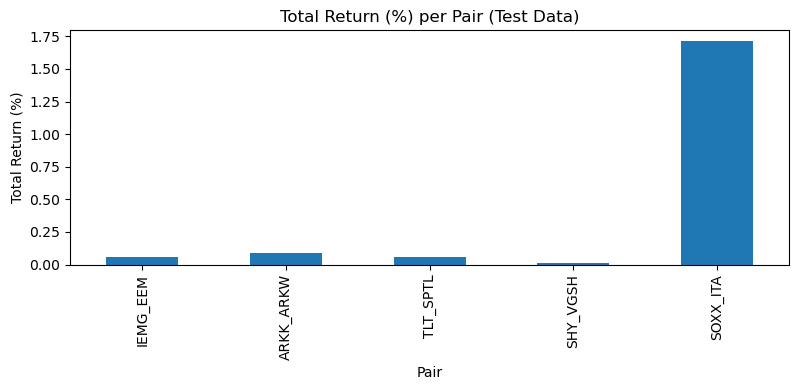

In [12]:
import pandas as pd
import numpy as np

pair_results = []

# Analyze each pair separately
for pair_name in test_df["pair"].unique():
    pair_df = test_df[test_df["pair"] == pair_name]
    final_cash, equity_curve, curve_dates = simulate_portfolio(pair_df, best_rf)
    
    equity_series = pd.Series(equity_curve, index=curve_dates)
    daily_returns = equity_series.pct_change().dropna()
    
    # Metrics
    start_value = equity_series.iloc[0]
    end_value = equity_series.iloc[-1]
    total_return = (end_value - start_value) / start_value * 100
    cagr = ((end_value / start_value) ** (252 / len(equity_series))) - 1 if len(equity_series) > 0 else 0
    sharpe = (daily_returns.mean() / daily_returns.std() * np.sqrt(252)) if len(daily_returns) > 0 else 0
    max_drawdown = ((equity_series.cummax() - equity_series) / equity_series.cummax()).max() * 100
    
    pair_results.append({
        "Pair": pair_name,
        "Final Value ($)": round(end_value, 2),
        "Total Return (%)": round(total_return, 2),
        "CAGR (%)": round(cagr * 100, 2),
        "Sharpe Ratio": round(sharpe, 2),
        "Max Drawdown (%)": round(max_drawdown, 2)
    })

# Create a DataFrame of results
pair_results_df = pd.DataFrame(pair_results)
print("\n📊 Mock Portfolio Performance per Pair:")
print(pair_results_df)

# Optional: plot bar chart for total returns
pair_results_df.plot(x="Pair", y="Total Return (%)", kind="bar", legend=False, figsize=(8, 4))
plt.title("Total Return (%) per Pair (Test Data)")
plt.ylabel("Total Return (%)")
plt.tight_layout()
plt.show()


These negative Sharpe ratios mean the strategy is underperforming — it's generating returns **worse than a risk-free investment**, with poor risk-adjusted performance. A Sharpe ratio below 0 typically signals that the portfolio may be losing money relative to its volatility.
